# PneumoniaMNIST Explainability Tutorial

This notebook demonstrates explainability analysis on **PneumoniaMNIST** - a binary classification dataset for pneumonia detection from chest X-rays.

## Overview

- **Dataset**: PneumoniaMNIST (MedMNIST)
- **Task**: Binary classification (Normal vs. Pneumonia)
- **Modality**: Pediatric chest X-rays (grayscale)
- **Classes**: 0 = Normal, 1 = Pneumonia
- **XAI Methods**: GradCAM, GradCAM++, Integrated Gradients, RISE
- **Goal**: Understand which lung regions influence pneumonia predictions

---

In [ ]:
# Google Colab Setup - Run this cell first!
import sys
import os

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Setting up environment...")
    
    # Install required packages
    print("\n Installing dependencies...")
    !pip install -q torch torchvision medmnist matplotlib numpy scipy scikit-learn scikit-image opencv-python tqdm
    
    # Clone the MedXAI repository
    if not os.path.exists('MedXAI'):
        print("\n Cloning MedXAI repository...")
        !git clone -q https://github.com/Matt-Cockayne/MedXAI.git
        sys.path.insert(0, '/content/MedXAI')
    else:
        sys.path.insert(0, '/content/MedXAI')
    
    print("✓ Environment setup complete!")
else:
    print(" Running locally")
    from pathlib import Path
    sys.path.insert(0, str(Path.cwd().parent))

print("Ready to go!")

## 1. Setup and Imports

Import necessary libraries and configure the environment for chest X-ray analysis.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import from MedXAI package
from utils import (
    get_medical_dataset, load_model, 
    visualize_comparison, plot_deletion_insertion_curves
)
from explainers import GradCAM, GradCAMPlusPlus, IntegratedGradients, RISE
from metrics import DeletionInsertion, FaithfulnessMetrics

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

✓ Imports successful
PyTorch version: 2.9.1+cu128
Using device: cuda


## 2. Install and Load MedMNIST

Ensure MedMNIST is installed for accessing the PneumoniaMNIST dataset.

In [ ]:
# Check if medmnist is installed
try:
    import medmnist
    print("medmnist package found")
except ImportError:
    print("Installing medmnist...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])
    import medmnist
    print("medmnist installed")

print(f"MedMNIST version: {medmnist.__version__}")

✓ medmnist package found
MedMNIST version: 3.0.2


## 3. Load PneumoniaMNIST Dataset

PneumoniaMNIST contains 28x28 grayscale chest X-ray images. We convert them to 3-channel and resize to 224x224 for ResNet50.

In [ ]:
# Ensure data directory exists
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)

# Custom transform for grayscale chest X-rays
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel for ResNet
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load PneumoniaMNIST test set
print("Loading PneumoniaMNIST dataset...")
test_dataset = get_medical_dataset(
    'pneumoniamnist',
    root=str(data_dir),
    split='test',
    transform=transform,
    download=True
)

# Dataset info
num_classes = 2
class_names = ['Normal', 'Pneumonia']

print(f"Dataset loaded: {len(test_dataset)} test images")
print(f"  Classes: {num_classes}")
print(f"  Image size: 28x28 grayscale (converted to 224x224 RGB)")
print(f"  Source: Pediatric chest X-ray images")
print(f"\nClass names:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Loading PneumoniaMNIST dataset...
✓ Dataset loaded: 624 test images
  Classes: 2
  Image size: 28x28 grayscale (converted to 224x224 RGB)
  Source: Pediatric chest X-ray images

Class names:
  0: Normal
  1: Pneumonia


## 4. Load Pre-trained Model

Load a ResNet50 model configured for binary pneumonia classification.

In [4]:
print("Loading ResNet50 model...")
model = load_model('resnet50', num_classes=num_classes, device=device)
model.eval()
print("✓ Model loaded and set to evaluation mode")
print(f"  Architecture: ResNet50")
print(f"  Output classes: {num_classes} (Binary classification)")

Loading ResNet50 model...
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 2 (Binary classification)
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 2 (Binary classification)


## 5. Initialize Explainability Methods

Initialize four different XAI techniques to explain pneumonia predictions.

In [5]:
print("Initializing explainability methods...")
explainers = {
    'GradCAM': GradCAM(model, 'layer4', device),
    'GradCAM++': GradCAMPlusPlus(model, 'layer4', device),
    'Integrated Gradients': IntegratedGradients(model, device),
    'RISE': RISE(model, device, n_masks=1000)
}

print(f"✓ {len(explainers)} methods initialized:")
for name in explainers.keys():
    print(f"  - {name}")

Initializing explainability methods...
✓ 4 methods initialized:
  - GradCAM
  - GradCAM++
  - Integrated Gradients
  - RISE


## 6. Select and Visualize a Sample

Select a chest X-ray image and display both the original and processed versions.

Sample #42
  True label: Normal (class 0)
  Predicted: Normal (class 0)
  Confidence: 0.503
  Normal prob: 0.503
  Pneumonia prob: 0.497
  Correct: ✓


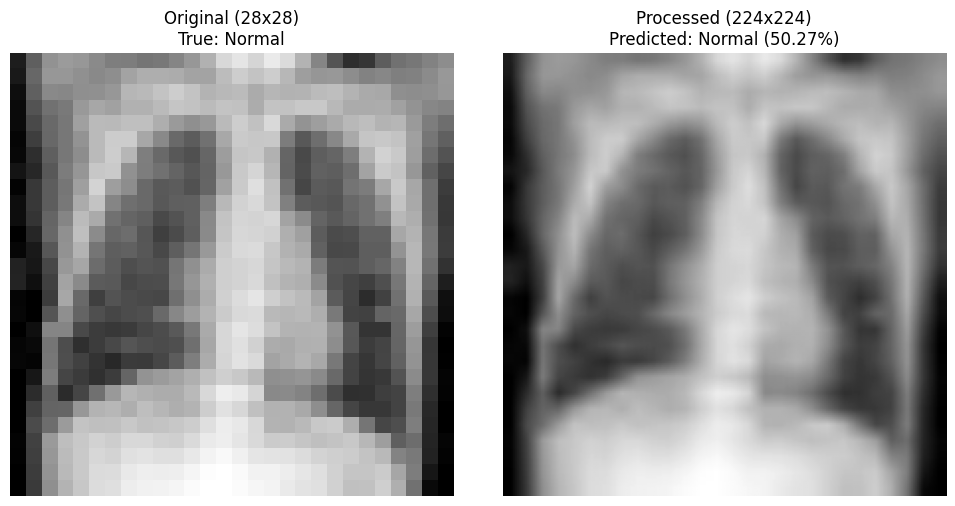

In [6]:
# Select a sample (you can change this index)
sample_idx = 42

# Get processed image and label
image, label = test_dataset[sample_idx]
label = int(label)  # Convert from numpy array to int
image_batch = image.unsqueeze(0).to(device)

# Load original image without transforms for visualization
from medmnist import INFO
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])
original_dataset = DataClass(split='test', download=False, root=str(data_dir), transform=None)
original_image = original_dataset[sample_idx][0]  # PIL Image

# Get model prediction
with torch.no_grad():
    output = model(image_batch)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_class = output.argmax(dim=1).item()
    confidence = probs[0, pred_class].item()
    
    # Also get probability for both classes
    prob_normal = probs[0, 0].item()
    prob_pneumonia = probs[0, 1].item()

# Display information
print(f"Sample #{sample_idx}")
print(f"  True label: {class_names[label]} (class {label})")
print(f"  Predicted: {class_names[pred_class]} (class {pred_class})")
print(f"  Confidence: {confidence:.3f}")
print(f"  Normal prob: {prob_normal:.3f}")
print(f"  Pneumonia prob: {prob_pneumonia:.3f}")
print(f"  Correct: {'✓' if label == pred_class else '✗'}")

# Visualize both versions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original 28x28
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(f'Original (28x28)\nTrue: {class_names[label]}')
axes[0].axis('off')

# Processed 224x224
img_display = image[0].cpu().numpy()  # Take first channel (all channels are same)
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[1].imshow(img_display, cmap='gray')
axes[1].set_title(f'Processed (224x224)\nPredicted: {class_names[pred_class]} ({confidence:.2%})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 7. Generate Explanations

Generate saliency maps showing which lung regions influenced the pneumonia prediction.

In [7]:
print("Generating explanations...\n")
explanations = {}

for name, explainer in explainers.items():
    print(f"  Generating {name}...", end=' ')
    try:
        explanation = explainer.explain(image_batch, target_class=label)
        explanations[name] = explanation
        print(f"✓ Shape: {explanation.shape}")
    except Exception as e:
        print(f"✗ Error: {e}")

print(f"\n✓ Generated {len(explanations)} explanations")

Generating explanations...

  Generating GradCAM... ✓ Shape: torch.Size([224, 224])
  Generating GradCAM++... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations
✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations


## 8. Visualize Explanation Comparison

Display all explanations as heatmaps overlaid on the chest X-ray. Red/warm regions indicate areas that most influenced the model's decision.

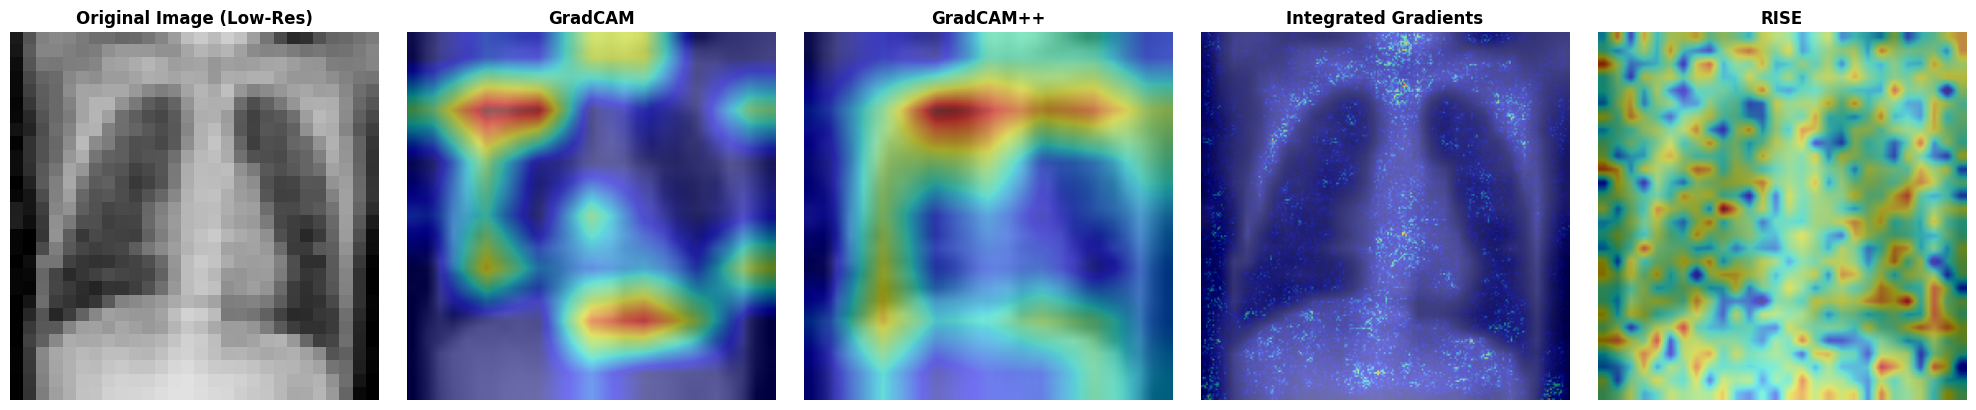


Interpretation:
  - Warm colors (red/yellow) = regions that strongly influenced the prediction
  - Cool colors (blue) = less influential regions
  - For pneumonia: Look for opacity patterns, infiltrates, consolidation
  - For normal: Explanations may be more diffuse or lung boundary-focused


In [8]:
# Create comprehensive visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=None
)
plt.show()

print("\nInterpretation:")
print("  - Warm colors (red/yellow) = regions that strongly influenced the prediction")
print("  - Cool colors (blue) = less influential regions")
print("  - For pneumonia: Look for opacity patterns, infiltrates, consolidation")
print("  - For normal: Explanations may be more diffuse or lung boundary-focused")

## 9. Quantitative Evaluation: Deletion & Insertion

Measure explanation quality using deletion and insertion metrics.

In [9]:
print("Computing Deletion/Insertion metrics...\n")
di_metric = DeletionInsertion(model, device, n_steps=50)
results = {}

for name, heatmap in explanations.items():
    print(f"  Evaluating {name}...", end=' ')
    try:
        result = di_metric.evaluate(image_batch, heatmap, label)
        results[name] = result
        print(f"Del: {result['deletion_auc']:.3f}, Ins: {result['insertion_auc']:.3f}")
    except Exception as e:
        print(f"Error: {e}")

print("\n✓ Evaluation complete")

Computing Deletion/Insertion metrics...

  Evaluating GradCAM... Del: 0.479, Ins: 0.474
  Evaluating GradCAM++... Del: 0.479, Ins: 0.474
  Evaluating GradCAM++... Del: 0.482, Ins: 0.465
  Evaluating Integrated Gradients... Del: 0.482, Ins: 0.465
  Evaluating Integrated Gradients... Del: 0.439, Ins: 0.449
  Evaluating RISE... Del: 0.439, Ins: 0.449
  Evaluating RISE... Del: 0.472, Ins: 0.460

✓ Evaluation complete
Del: 0.472, Ins: 0.460

✓ Evaluation complete


## 10. Plot Deletion & Insertion Curves

Visualize how confidence changes as important pixels are removed (deletion) or added (insertion).

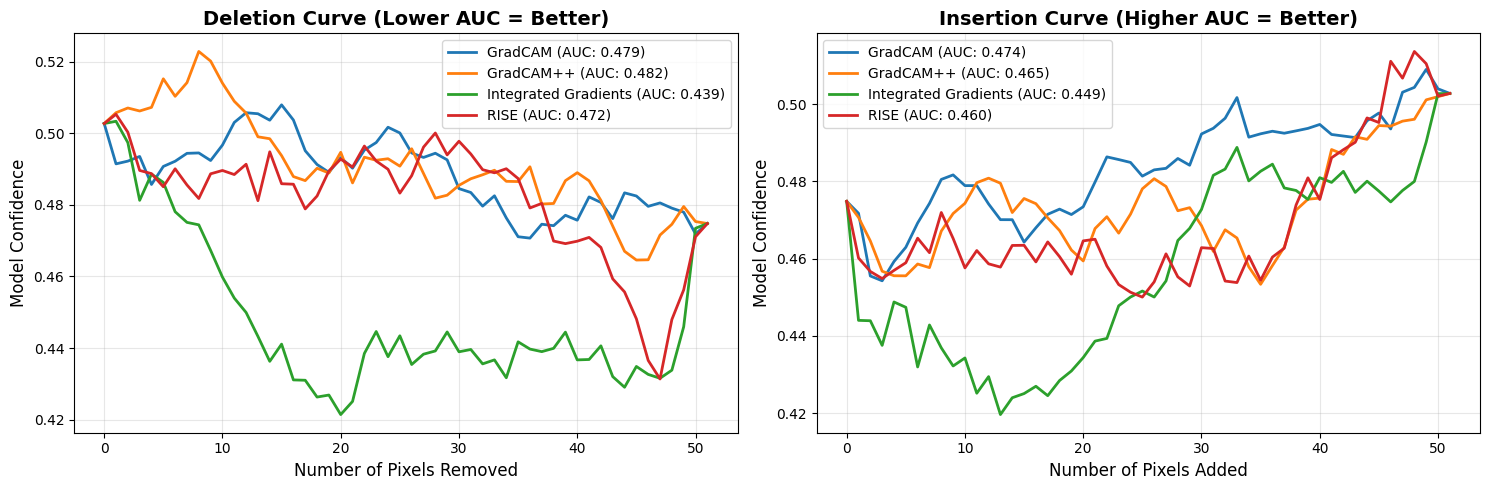


Interpretation:
  Deletion curve: Confidence should drop faster for better explanations
  Insertion curve: Confidence should rise faster for better explanations
  Lower deletion AUC = better
  Higher insertion AUC = better


In [10]:
if results:
    fig = plot_deletion_insertion_curves(results, save_path=None)
    plt.show()
    
    print("\nInterpretation:")
    print("  Deletion curve: Confidence should drop faster for better explanations")
    print("  Insertion curve: Confidence should rise faster for better explanations")
    print("  Lower deletion AUC = better")
    print("  Higher insertion AUC = better")

## 11. Faithfulness Metrics

Compute additional metrics to assess how faithfully explanations represent the model's reasoning.

In [11]:
print("Computing faithfulness metrics for top methods...\n")
faith_metric = FaithfulnessMetrics(model, device)

# Evaluate top 2 methods
for name, heatmap in list(explanations.items())[:2]:
    print(f"  {name}:")
    try:
        metrics = faith_metric.evaluate_all(image_batch, heatmap, label)
        for metric_name, value in metrics.items():
            print(f"    - {metric_name}: {value:.3f}")
        print()
    except Exception as e:
        print(f"    Error: {e}\n")

Computing faithfulness metrics for top methods...

  GradCAM:
    - sensitivity_n: -0.190
    - infidelity: 177.750
    - monotonicity: 0.490

  GradCAM++:
    - sensitivity_n: -0.190
    - infidelity: 177.750
    - monotonicity: 0.490

  GradCAM++:
    - sensitivity_n: 0.056
    - infidelity: 188.920
    - monotonicity: 0.471

    - sensitivity_n: 0.056
    - infidelity: 188.920
    - monotonicity: 0.471



## 12. Clinical Interpretation Helper

Let's analyze the explanations in a clinical context.

In [12]:
print("=" * 70)
print("CLINICAL INTERPRETATION")
print("=" * 70)

print(f"\nCase: {class_names[label]} (Ground Truth)")
print(f"Model Diagnosis: {class_names[pred_class]} (Confidence: {confidence:.2%})\n")

if label == 1:  # Pneumonia
    print("What to look for in explanations (Pneumonia):")
    print("  ✓ Focal areas of opacity (consolidation)")
    print("  ✓ Interstitial infiltrates")
    print("  ✓ Areas of increased density in lung fields")
    print("  ✓ Potentially both lungs (bilateral) or single lung")
else:  # Normal
    print("What to look for in explanations (Normal):")
    print("  ✓ Even distribution across lung fields")
    print("  ✓ Attention to lung boundaries/diaphragm")
    print("  ✓ No focal areas of high importance")
    print("  ✓ Symmetric patterns")

print("\nNote: These are model-learned features, not definitive clinical markers.")
print("Always consult with radiologists for clinical diagnosis.")
print("\n" + "=" * 70)

CLINICAL INTERPRETATION

Case: Normal (Ground Truth)
Model Diagnosis: Normal (Confidence: 50.27%)

What to look for in explanations (Normal):
  ✓ Even distribution across lung fields
  ✓ Attention to lung boundaries/diaphragm
  ✓ No focal areas of high importance
  ✓ Symmetric patterns

Note: These are model-learned features, not definitive clinical markers.
Always consult with radiologists for clinical diagnosis.



## 13. Results Summary

Summarize and rank all methods by their performance metrics.

In [13]:
print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

print(f"\nSample: {class_names[label]} (True) → {class_names[pred_class]} (Predicted)\n")

print("Deletion AUC Rankings (lower is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['deletion_auc']), 1):
    print(f"  {i}. {method:25s}: {result['deletion_auc']:.4f}")

print("\nInsertion AUC Rankings (higher is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['insertion_auc'], reverse=True), 1):
    print(f"  {i}. {method:25s}: {result['insertion_auc']:.4f}")

print("\n" + "=" * 70)

RESULTS SUMMARY

Sample: Normal (True) → Normal (Predicted)

Deletion AUC Rankings (lower is better):
  1. Integrated Gradients     : 0.4389
  2. RISE                     : 0.4723
  3. GradCAM                  : 0.4791
  4. GradCAM++                : 0.4820

Insertion AUC Rankings (higher is better):
  1. GradCAM                  : 0.4743
  2. GradCAM++                : 0.4646
  3. RISE                     : 0.4598
  4. Integrated Gradients     : 0.4486



## 14. Save Results (Optional)

Save all visualizations and results for documentation.

In [ ]:
# Create output directory
output_dir = Path('./results/pneumoniamnist')
output_dir.mkdir(parents=True, exist_ok=True)

# Save original image
original_image.save(output_dir / f'sample_{sample_idx}_original.png')
print(f"✓ Saved original image")

# Save comparison visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=output_dir / f'sample_{sample_idx}_comparison.png'
)
plt.close(fig)
print(f"✓ Saved comparison visualization")

# Save curves
if results:
    fig = plot_deletion_insertion_curves(
        results,
        save_path=output_dir / f'sample_{sample_idx}_curves.png'
    )
    plt.close(fig)
    print(f"✓ Saved deletion/insertion curves")

print(f"\nAll results saved to: {output_dir}")

✓ Saved original image
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/pneumoniamnist
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/pneumoniamnist


: 

## Conclusion

This notebook demonstrated explainability analysis for **pneumonia detection** from chest X-rays:

### What We Covered:

1. ✓ Loaded PneumoniaMNIST dataset (binary classification)
2. ✓ Handled grayscale medical images properly
3. ✓ Generated explanations with 4 different methods
4. ✓ Visualized important regions for pneumonia detection
5. ✓ Quantitatively evaluated explanation quality
6. ✓ Provided clinical interpretation context

### Key Insights:

- **Pneumonia cases**: Models typically focus on areas of opacity and infiltrates
- **Normal cases**: Explanations tend to be more distributed across lung fields
- **Method comparison**: Different XAI methods may highlight complementary regions
- **Validation**: Quantitative metrics help assess explanation reliability

### Clinical Relevance:

- Explanations can help radiologists understand model decisions
- Identify when models focus on clinically relevant features
- Detect potential biases (e.g., focusing on artifacts rather than pathology)
- Build trust through transparent AI decision-making

### Next Steps:

- Test on more samples, especially edge cases
- Compare explanations for correct vs. incorrect predictions
- Analyze class-specific patterns (Normal vs. Pneumonia)
- Try ChestMNIST for multi-disease classification